# SEISMIC DETECTION: TWO STEPS ENSEMBLE ALGORITHM
This notebook describes and applies our chosen approach to solving the challenge.

We opted to use the STA/LTA (Short-Term Average/Long-Term Average) algorithm with a grid of hyperparameters that minimize the absolute time error to obtain candidate seismic windows.

From the detected candidate windows, we select the one with the highest number of anomalies, identified using an Isolation Forest.

With this approach, we achieved a mean absolute error of nn seconds in a sample of 50 tested files.


In [ ]:
from itertools import product

def evaluate_sta_lta(tr_data, sta_len, lta_len, thr_on, thr_off, real_arrival, sampling_rate):

    cft = classic_sta_lta(tr_data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) == 0:
        return float('inf'), 0  # Penalización por no detectar nada
    elif len(on_off) > 1:
        return float('inf'), len(on_off)  # Penalización por detectar múltiples eventos

    # Solo un trigger detectado
    detected_time = on_off[0][0] / sampling_rate
    time_diff = abs(detected_time - real_arrival)

    return time_diff, 1

def optimize_sta_lta(archivos, ruta_entrenamiento, cat, param_grid):
    best_score = float('inf')
    best_params = {}

    for sta_len, lta_len, thr_on, thr_off in product(param_grid['sta_len'], param_grid['lta_len'],
                                                     param_grid['thr_on'], param_grid['thr_off']):
        total_diff = 0
        valid_files = 0
        multiple_detections = 0

        for nombre_archivo in archivos:
            try:
                # Leer los datos
                data = read(f"{ruta_entrenamiento}{nombre_archivo}.mseed")
                tr = data.traces[0].copy()
                tr_data = tr.data
                sampling_rate = tr.stats.sampling_rate
                starttime = tr.stats.starttime.datetime

                # Obtener el tiempo de llegada real
                fila_cat = cat[cat['filename'] == nombre_archivo].iloc[0]
                arrival_time = datetime.strptime(fila_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
                real_arrival = (arrival_time - starttime).total_seconds()

                diff, num_detections = evaluate_sta_lta(tr_data, sta_len, lta_len, thr_on, thr_off, real_arrival, sampling_rate)

                if num_detections == 1:
                    total_diff += diff
                    valid_files += 1
                elif num_detections > 1:
                    multiple_detections += 1

            except Exception as e:
                print(f"Error procesando el archivo {nombre_archivo}: {str(e)}")
                continue

        # Calculamos el score considerando tanto la precisión como la unicidad de las detecciones
        if valid_files > 0:
            avg_diff = total_diff / valid_files
            detection_ratio = valid_files / len(archivos)
            score = avg_diff / detection_ratio  # Penalizamos si hay menos detecciones únicas

            if score < best_score:
                best_score = score
                best_params = {'sta_len': sta_len, 'lta_len': lta_len, 'thr_on': thr_on, 'thr_off': thr_off}

        print(f"Parámetros: STA={sta_len}, LTA={lta_len}, ON={thr_on}, OFF={thr_off}")
        print(f"Archivos con detección única: {valid_files}/{len(archivos)}")
        print(f"Archivos con múltiples detecciones: {multiple_detections}")
        print(f"Score actual: {score if valid_files > 0 else float('inf')}")
        print("-----")

    return best_params, best_score

# Ejemplo de uso:
ruta_entrenamiento = './data/lunar/training/data/S12_GradeA/'
archivos = list(cat["filename"].unique())[1:10]

param_grid = {
    'sta_len': [30, 60, 90, 120, 150, 180, 210],
    'lta_len': [300, 450, 600, 750, 900, 1050, 1200],
    'thr_on': [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0],
    'thr_off': [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
}

best_params, best_score = optimize_sta_lta(archivos, ruta_entrenamiento, cat, param_grid)
print(f"Mejores parámetros: {best_params}")
print(f"Mejor score: {best_score}")

# LIBRARIES

In [ ]:
!pip install obspy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import obspy
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from dataclasses import dataclass
from typing import Optional, Dict
from collections import defaultdict
from tqdm import tqdm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
from itertools import product
from scipy import stats

In [ ]:
cat_directory = '/content/drive/My Drive/NASA/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


# STA/LTA
The following code processes seismic data files to detect and characterize seismic events using the STA/LTA (Short-Term Average over Long-Term Average) algorithm.

It reads seismic traces, computes the characteristic function (CFT) to highlight potential events, and identifies triggers where the CFT exceeds specified thresholds. For each detected event, it extracts a range of statistical features, such as duration, peak values, and statistical moments to create a detailed DataFrame of event characteristics. This could be use as a potential features for future approaches.

This procedure is applied to all files in the dataset, aggregating the results into a single DataFrame for the posterior proccess (Isolation forest)

In [ ]:
#Importacion y muestreo del catalogo
cat_mars_directory = '/content/drive/My Drive/NASA/data/mars/training/catalogs/'
cat_lunar_directory = '/content/drive/My Drive/NASA/data/lunar/training/catalogs/'
cat_file_lunar = cat_lunar_directory + 'apollo12_catalog_GradeA_final.csv'
cat_file_mars = cat_mars_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file_lunar)
#cat.head()
np.random.seed(42)
muestra_cat = cat.sample(n=50, random_state=42)
muestra_cat.set_index('filename', inplace=True)
restantes_cat = cat.loc[~cat.index.isin(muestra_cat.index)]
#restantes_cat.set_index('filename', inplace=True)
#print(muestra_cat["filename"].unique())

In [ ]:
def create_trigger_dataframe(cft, nombre_archivo, arrival, on_off, tr_times):
    trigger_data = []
    for i, (on, off) in enumerate(on_off):
        cft_segment = cft[on:off+1]
        trigger_data.append({
            'Filename': nombre_archivo,
            'Trigger': i + 1,
            'On Time': tr_times[on],
            'Off Time': tr_times[off],
            'Arrival' : arrival,
            'On Index': on,
            'Off Index': off,
            'Duration': tr_times[off] - tr_times[on],
            'CFT On': cft[on],
            'CFT Off': cft[off],
            'CFT Max': np.max(cft_segment),
            'CFT Min': np.min(cft_segment),
            'CFT Mean': np.mean(cft_segment),
            'CFT Median': np.median(cft_segment),
            'CFT Std': np.std(cft_segment),
            'CFT Skewness': stats.skew(cft_segment),
            'CFT Kurtosis': stats.kurtosis(cft_segment),
            'CFT Q1': np.percentile(cft_segment, 25),
            'CFT Q3': np.percentile(cft_segment, 75),
            'CFT IQR': np.percentile(cft_segment, 75) - np.percentile(cft_segment, 25),
            'CFT Range': np.max(cft_segment) - np.min(cft_segment),
            'CFT Coeff of Variation': np.std(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Peak to Mean Ratio': np.max(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Area Under Curve': np.trapz(cft_segment, tr_times[on:off+1]),
            'CFT Max Index': on + np.argmax(cft_segment),
            'CFT Max Time': tr_times[on + np.argmax(cft_segment)],
            'CFT Slope': np.polyfit(tr_times[on:off+1], cft_segment, 1)[0],
            'Arrival' : arrival
        })

    df = pd.DataFrame(trigger_data)
    return df


## Función que toma un archivo y devuelve el dataframe de activaciones
def obtencion_ventanas_sta_lta(nombre_archivo, planeta):
    # Lectura de los datos
    if planeta.lower() == "luna":
        ruta_entrenamiento = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
    elif planeta.lower() == "marte":
        ruta_entrenamiento = '/content/drive/My Drive/NASA/data/mars/training/data/'
    else:
        raise ValueError("El planeta debe ser 'luna' o 'marte'")

    # Importacion de los datos y extraccion de sus variables
    data = read(f"{ruta_entrenamiento}{nombre_archivo}.mseed")
    tr = data.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    fila_cat = cat[cat['filename'] == nombre_archivo].iloc[0]
    arrival_time = datetime.strptime(fila_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    # Definimos los hiperparametros obtenidos en el proceso de busqueda
    df = tr.stats.sampling_rate
    sta_len = 180
    lta_len = 1200
    thr_on = 4
    thr_off = 0.5

    # Obtenemos la funcion de caracteristicas y los distintos triggers
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    df_triggers = create_trigger_dataframe(cft, nombre_archivo,arrival, on_off, tr_times)
    return df_triggers


def procesar_todos_los_archivos(muestra_cat, planeta):
    todos_los_triggers = []
    for nombre_archivo in tqdm(muestra_cat["filename"], desc="Procesando archivos"):
        try:
            df_triggers = obtencion_ventanas_sta_lta(nombre_archivo, planeta)
            df_triggers['archivo_origen'] = nombre_archivo
            todos_los_triggers.append(df_triggers)
        except Exception as e:
            print(f"Error procesando {nombre_archivo}: {str(e)}")

    # Concatenamos todos los DataFrames en uno solo
    df_final = pd.concat(todos_los_triggers, ignore_index=True)
    return df_final


In [ ]:
planeta = "luna"
df_final = procesar_todos_los_archivos(muestra_cat, planeta)

Procesando archivos: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it]


# ISOLATION FOREST
To obtain the window or trigger that truly represents the seism, we calculate for each point in the series its anomaly coefficient, obtained with isolation forest.

[Wank, P. (2019). Discover Unusual Patterns in Time Series Data with Unsupervised Anomaly Detection and Isolation Forest. *Medium*.](https://medium.com/@pw33392/discover-unusual-patterns-in-time-series-data-with-unsupervised-anomaly-detection-and-isolation-78db408caaed)

In [ ]:
@dataclass
class IsolationTree:
    X: np.ndarray
    indices: np.ndarray
    max_depth: int
    left: Optional['IsolationTree'] = None
    right: Optional['IsolationTree'] = None
    split_feature: Optional[int] = None
    split_value: Optional[float] = None

    def __post_init__(self):
        if self.X.shape[0] <= 1 or self.max_depth <= 0:
            return


        self.split_feature = np.random.randint(self.X.shape[1])

        min_val = self.X[:, self.split_feature].min()
        max_val = self.X[:, self.split_feature].max()
        if min_val == max_val:
            return
        self.split_value = np.random.uniform(min_val, max_val)

        left_indices = self.X[:, self.split_feature] < self.split_value
        right_indices = self.X[:, self.split_feature] >= self.split_value

        self.left = IsolationTree(self.X[left_indices], self.indices[left_indices], self.max_depth - 1)
        self.right = IsolationTree(self.X[right_indices], self.indices[right_indices], self.max_depth - 1)

    def path_lengths(self) -> Dict[int, int]:
        if self.left is None and self.right is None:
            return {idx: 1 for idx in self.indices}

        path_lengths = {}
        if self.left is not None:
            left_path_lengths = self.left.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in left_path_lengths.items()})
        if self.right is not None:
            right_path_lengths = self.right.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in right_path_lengths.items()})
        return path_lengths

def isolation_forest_for_time_series(X: np.ndarray, window_size: int, n_trees: int, max_depth: int, sample_frac: float) -> np.ndarray:

    windows = np.lib.stride_tricks.sliding_window_view(X, window_size)
    num_windows = windows.shape[0]
    indices = np.arange(num_windows)

    path_lengths_sum = defaultdict(int)
    path_lengths_counts = defaultdict(int)
    for _ in range(n_trees):

        sample_size = max(1, int(num_windows * sample_frac))
        sample_indices = np.random.choice(num_windows, size=sample_size, replace=False)
        sample_windows = windows[sample_indices]
        tree = IsolationTree(sample_windows, sample_indices, max_depth)
        path_lengths = tree.path_lengths()
        for idx, path_length in path_lengths.items():
            path_lengths_sum[idx] += path_length
            path_lengths_counts[idx] += 1

    avg_path_lengths = np.array([path_lengths_sum[idx] / path_lengths_counts[idx] for idx in range(num_windows)])
    c = 2 * (np.log(num_windows - 1) + 0.5772156649) - (2 * (num_windows - 1) / num_windows)
    anomaly_scores = 2 ** (-avg_path_lengths / c)
    return anomaly_scores

In [ ]:
def plot_seismic_trace_by_filename(cat, filename, data_directory):
    try:
        row = cat.loc[filename]
    except KeyError:
        print(f"No se encontró el archivo {filename} en el catálogo.")
        return

    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]

    arrival_time_str = row['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
    arrival_time = datetime.strptime(arrival_time_str,'%Y-%m-%dT%H:%M:%S.%f')

    mseed_file = f'{data_directory}{filename}.mseed'

    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error al leer el archivo {mseed_file}: {e}")
        return

    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime

    arrival = (arrival_time - starttime).total_seconds()
    # fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    # ax.plot(tr_times, tr_data)
    # ax.axvline(x=arrival, color='red', label='Tiempo de llegada relativo')
    # ax.legend(loc='upper left')
    # ax.set_xlim([min(tr_times), max(tr_times)])
    # ax.set_ylabel('Velocidad (m/s)')
    # ax.set_xlabel('Tiempo (s)')
    # ax.set_title(f'{filename}', fontweight='bold')
    #plt.show()
    return tr_times, tr_data

In [ ]:
for filename in muestra_cat.index:
  print(filename)

xa.s12.00.mhz.1970-04-26HR00_evid00007
xa.s12.00.mhz.1972-06-16HR00_evid00060
xa.s12.00.mhz.1970-10-24HR00_evid00014
xa.s12.00.mhz.1970-01-19HR00_evid00002
xa.s12.00.mhz.1973-03-13HR00_evid00094
xa.s12.00.mhz.1973-05-14HR00_evid00104
xa.s12.00.mhz.1974-04-27HR00_evid00145
xa.s12.00.mhz.1973-07-04HR00_evid00114
xa.s12.00.mhz.1973-06-18HR00_evid00109
xa.s12.00.mhz.1971-10-18HR00_evid00043
xa.s12.00.mhz.1974-07-06HR00_evid00150
xa.s12.00.mhz.1974-07-17HR00_evid00153
xa.s12.00.mhz.1971-02-09HR00_evid00026
xa.s12.00.mhz.1970-12-11HR00_evid00017
xa.s12.00.mhz.1974-01-10HR00_evid00136
xa.s12.00.mhz.1972-03-12HR00_evid00052
xa.s12.00.mhz.1970-09-26HR00_evid00013
xa.s12.00.mhz.1970-06-15HR00_evid00008
xa.s12.00.mhz.1972-05-11HR00_evid00055
xa.s12.00.mhz.1971-05-12HR00_evid00031
xa.s12.00.mhz.1971-10-31HR00_evid00045
xa.s12.00.mhz.1972-12-02HR00_evid00083
xa.s12.00.mhz.1972-07-31HR00_evid00071
xa.s12.00.mhz.1971-01-28HR00_evid00023
xa.s12.00.mhz.1974-04-26HR00_evid00144
xa.s12.00.mhz.1973-07-20H

In [ ]:
def obtencion_anomalias(planeta):
  if planeta.lower() == "luna":
        data_directory = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
  elif planeta.lower() == "marte":
        data_directory = '/content/drive/My Drive/NASA/data/mars/training/data/'
  else:
        raise ValueError("El planeta debe ser 'luna' o 'marte'")
  todos_los_archivos = []
  for filename in muestra_cat.index:
    tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat, filename, data_directory)
    df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})
    X = df['velocity'].values
    window_size = 50
    n_trees = 100
    max_depth = 10
    sample_frac = 0.5
    anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)
    scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
    window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)
    threshold = np.percentile(anomaly_scores, 95)
    anomalies = anomaly_scores > threshold
    anomaly_times = window_times[anomalies]
    anomaly_df = pd.DataFrame({'time': anomaly_times, 'Filename': filename})
    todos_los_archivos.append(anomaly_df)

  anomaly_df = pd.concat(todos_los_archivos, ignore_index=True)
  return anomaly_df

In [ ]:
anomaly_df = obtencion_anomalias("luna")

In [ ]:
data_directory = '/content/drive/My Drive/NASA/data/lunar/training/data/S12_GradeA/'
filename = 'xa.s12.00.mhz.1972-06-16HR00_evid00060'
tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat, filename, data_directory)

In [ ]:
df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})

In [ ]:
X = df['velocity'].values

In [ ]:
window_size = 50
n_trees = 100
max_depth = 10
sample_frac = 0.5

anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)

In [ ]:
scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)

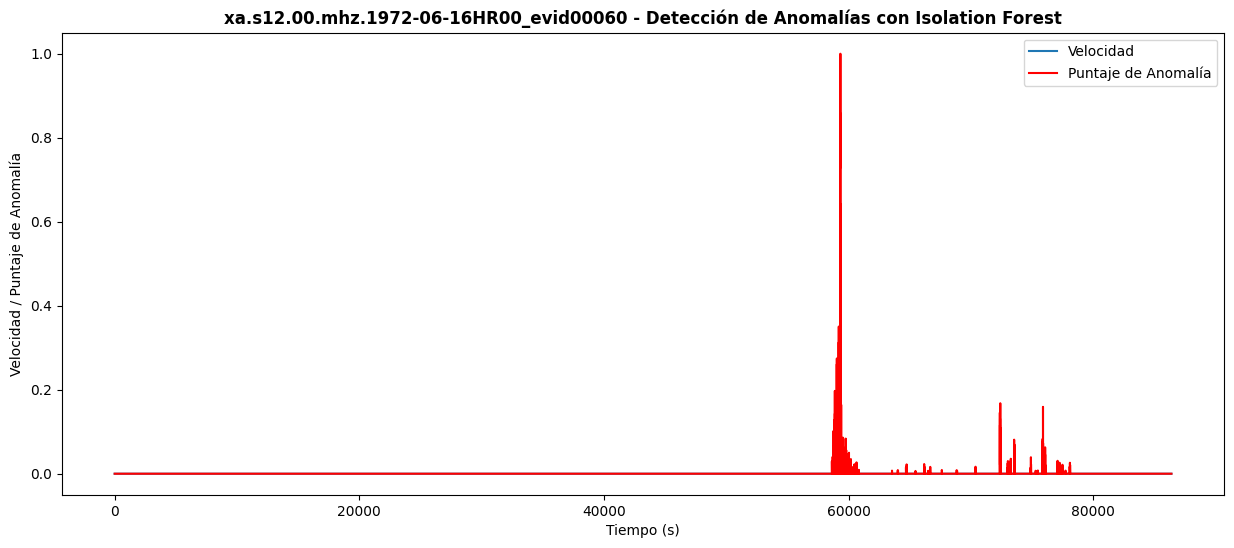

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['velocity'], label='Velocidad')
plt.plot(window_times, scaled_anomaly_scores, label='Puntaje de Anomalía', color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad / Puntaje de Anomalía')
plt.title(f'{filename} - Detección de Anomalías con Isolation Forest', fontweight='bold')
plt.legend()
plt.show()

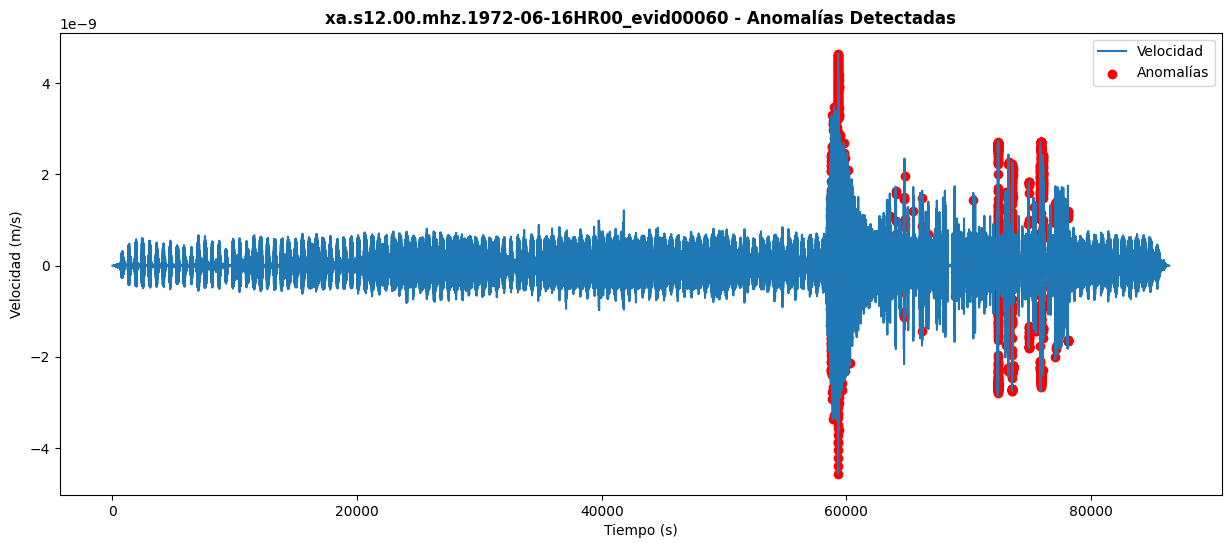

In [ ]:
threshold = np.percentile(anomaly_scores, 95)
anomalies = anomaly_scores > threshold
anomaly_times = window_times[anomalies]

plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['velocity'], label='Velocidad')
plt.scatter(anomaly_times, df['velocity'].iloc[anomaly_times.index], color='red', label='Anomalías')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title(f'{filename} - Anomalías Detectadas', fontweight='bold')
plt.legend()
plt.show()

Approach por diferencias (segmentos)

In [ ]:
anomaly_df = pd.DataFrame({'time': anomaly_times, 'Filename': filename}) # dataframe con los tiempos de las anomalias
anomaly_df.head()9

,time,Filename
388442,58640.150943,xa.s12.00.mhz.1972-06-16HR00_evid00060
388541,58655.094340,xa.s12.00.mhz.1972-06-16HR00_evid00060
388666,58673.962264,xa.s12.00.mhz.1972-06-16HR00_evid00060
388695,58678.339623,xa.s12.00.mhz.1972-06-16HR00_evid00060
388753,58687.094340,xa.s12.00.mhz.1972-06-16HR00_evid00060


In [ ]:
def contar_anomalias(row, anomaly_df):
    # Filtrar anomalías para el archivo actual
    anomalias_archivo = anomaly_df[anomaly_df['Filename'] == row['Filename']]
    # print(anomalias_archivo)

    # Contar anomalías dentro del intervalo de tiempo
    count = anomalias_archivo[(anomalias_archivo['time'] >= row['On Time']) &
                              (anomalias_archivo['time'] <= row['Off Time'])].shape[0]

    return count

In [ ]:
df_final['conteo_anomalias'] = df_final.apply(lambda row: contar_anomalias(row, anomaly_df), axis=1)

In [ ]:
df_final

,Filename,Trigger,On Time,Off Time,Arrival,On Index,Off Index,Duration,CFT On,CFT Off,...,CFT IQR,CFT Range,CFT Coeff of Variation,CFT Peak to Mean Ratio,CFT Area Under Curve,CFT Max Index,CFT Max Time,CFT Slope,archivo_origen,conteo_anomalias
0,xa.s12.00.mhz.1970-04-26HR00_evid00007,1.0,52368.603774,53477.735849,52139.340,346942.0,354290.0,1109.132075,4.001679,0.501401,...,2.582910,4.864144,0.705800,2.390254,2489.733954,347732.0,52487.849057,-0.004594,xa.s12.00.mhz.1970-04-26HR00_evid00007,2407
1,xa.s12.00.mhz.1972-06-16HR00_evid00060,1.0,1374.490566,1605.735849,58259.884,9106.0,10638.0,231.245283,4.002145,0.501209,...,2.520636,3.886316,0.456733,1.486571,682.612072,9489.0,1432.301887,-0.018926,xa.s12.00.mhz.1972-06-16HR00_evid00060,0
2,xa.s12.00.mhz.1972-06-16HR00_evid00060,2.0,7064.905660,7297.207547,58259.884,46805.0,48344.0,232.301887,4.002322,0.501548,...,3.043174,4.105532,0.524264,1.668319,641.581147,47072.0,7105.207547,-0.020817,xa.s12.00.mhz.1972-06-16HR00_evid00060,0
3,xa.s12.00.mhz.1972-06-16HR00_evid00060,3.0,9949.584906,10129.509434,58259.884,65916.0,67108.0,179.924528,4.002181,0.502813,...,2.660745,3.713263,0.499625,1.616043,469.456769,66069.0,9972.679245,-0.024600,xa.s12.00.mhz.1972-06-16HR00_evid00060,0
4,xa.s12.00.mhz.1972-06-16HR00_evid00060,4.0,58742.188679,59993.811321,58259.884,389167.0,397459.0,1251.622642,4.000639,0.500770,...,2.073927,3.733293,0.614585,2.132892,2484.591113,389579.0,58804.377358,-0.003198,xa.s12.00.mhz.1972-06-16HR00_evid00060,2261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,xa.s12.00.mhz.1975-06-24HR00_evid00196,6.0,8019.622642,8261.433962,57779.761,53130.0,54732.0,241.811321,4.018565,0.511671,...,1.407501,6.076152,0.308224,1.181235,1349.096726,53623.0,8094.037736,-0.014897,xa.s12.00.mhz.1975-06-24HR00_evid00196,386
416,xa.s12.00.mhz.1975-06-24HR00_evid00196,7.0,9607.849057,9838.792453,57779.761,63652.0,65182.0,230.943396,4.019029,0.507326,...,0.978605,4.426276,0.347787,1.257610,906.241372,63918.0,9648.000000,-0.015502,xa.s12.00.mhz.1975-06-24HR00_evid00196,0
417,xa.s12.00.mhz.1975-06-24HR00_evid00196,8.0,48951.547170,49260.075472,57779.761,324304.0,326348.0,308.528302,4.002995,0.500404,...,3.896352,3.961627,0.694929,1.790034,769.106928,324543.0,48987.622642,-0.018179,xa.s12.00.mhz.1975-06-24HR00_evid00196,0
418,xa.s12.00.mhz.1975-06-24HR00_evid00196,9.0,57849.660377,58338.566038,57779.761,383254.0,386493.0,488.905660,4.040600,0.500667,...,4.665207,5.564800,0.678460,1.898659,1562.000442,384266.0,58002.415094,-0.014165,xa.s12.00.mhz.1975-06-24HR00_evid00196,562


In [ ]:
df_seism = df_final.loc[df_final.groupby('Filename')['conteo_anomalias'].idxmax()]
df_seism = df_seism.reset_index(drop=True)

print(df_seism)

                                  Filename  Trigger       On Time  \
0   xa.s12.00.mhz.1970-01-19HR00_evid00002     17.0  73523.773585   
1   xa.s12.00.mhz.1970-04-25HR00_evid00006      1.0   4770.566038   
2   xa.s12.00.mhz.1970-04-26HR00_evid00007      1.0  52368.603774   
3   xa.s12.00.mhz.1970-06-15HR00_evid00008     11.0  68494.188679   
4   xa.s12.00.mhz.1970-06-26HR00_evid00009      1.0  72191.245283   
5   xa.s12.00.mhz.1970-07-20HR00_evid00010      2.0  18488.905660   
6   xa.s12.00.mhz.1970-07-20HR00_evid00011      2.0  18488.905660   
7   xa.s12.00.mhz.1970-09-26HR00_evid00013      3.0  72059.018868   
8   xa.s12.00.mhz.1970-10-24HR00_evid00014      5.0  62215.547170   
9   xa.s12.00.mhz.1970-12-11HR00_evid00017      3.0  26644.830189   
10  xa.s12.00.mhz.1970-12-27HR00_evid00019      3.0  74201.056604   
11  xa.s12.00.mhz.1971-01-28HR00_evid00023      1.0  43068.830189   
12  xa.s12.00.mhz.1971-01-29HR00_evid00024      2.0  55997.132075   
13  xa.s12.00.mhz.1971-02-09HR00_e

La media de la diferencia absoluta entre Arrival y On Time es: 4484.477214863304


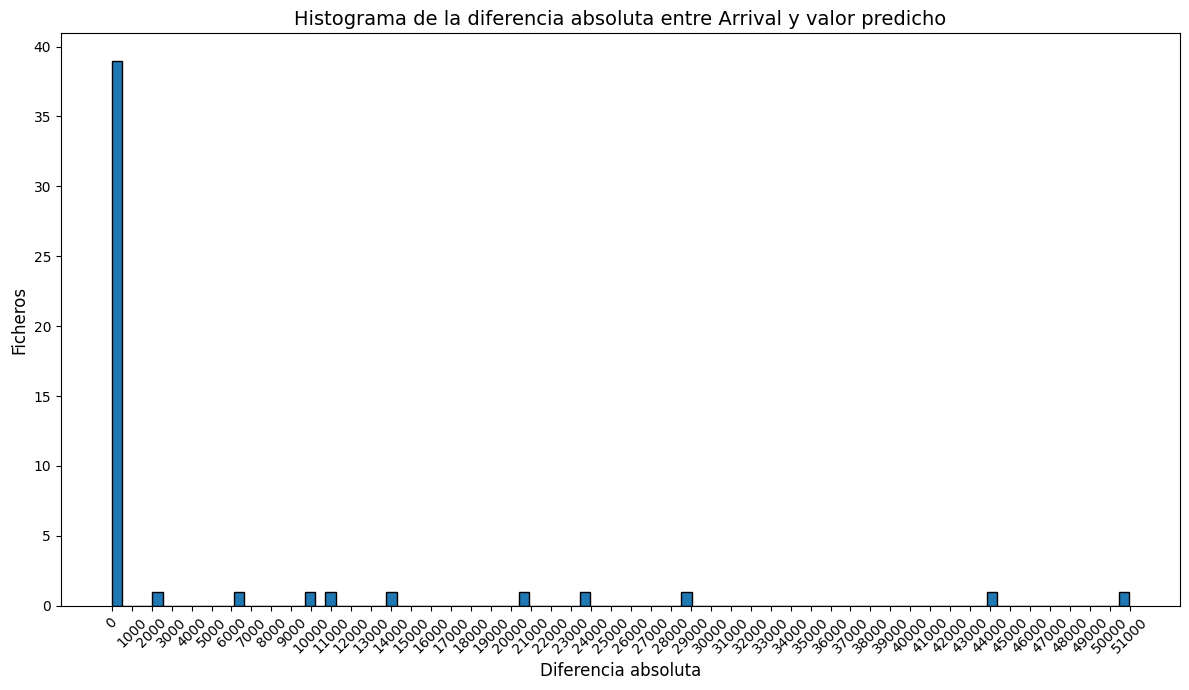

In [ ]:
df_seism['Arrival_On_Diff'] = abs(df_seism['Arrival'] - df_seism['On Time'])
mean_diff = df_seism['Arrival_On_Diff'].mean()
print(f"La media de la diferencia absoluta entre Arrival y On Time es: {mean_diff}")

# Crear el histograma
plt.figure(figsize=(12, 7))
plt.hist(df_seism['Arrival_On_Diff'], bins=100, edgecolor='black')
plt.title('Histograma de la diferencia absoluta entre Arrival y valor predicho', fontsize=14)
plt.xlabel('Diferencia absoluta', fontsize=12)
plt.ylabel('Ficheros', fontsize=12)

max_value = df_seism['Arrival_On_Diff'].max()
x_ticks = range(0, int(max_value) + 1000, 1000)
plt.xticks(x_ticks, rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# TEST DATA

In [ ]:
test_data_dir = '/content/drive/My Drive/NASA/test_data/'

In [ ]:
## Función para tener en una unica carpeta todos los mseed de test
cat_mars_directory_test = '/content/drive/My Drive/NASA/data/mars/test/data/'
cat_lunar_directory_test = '/content/drive/My Drive/NASA/data/lunar/test/data/'
import shutil
from pathlib import Path

def copy_mseed_files(source_dirs, destination_dir):
    Path(destination_dir).mkdir(parents=True, exist_ok=True)
    mseed_files = []
    for source_dir in source_dirs:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                if file.endswith('.mseed'):
                    full_path = os.path.join(root, file)
                    mseed_files.append(full_path)

    for file_path in mseed_files:
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(destination_dir, file_name)
        shutil.copy2(file_path, destination_path)
        print(f"Copiado: {file_path} -> {destination_path}")

    return len(mseed_files)

# Directorios fuente
cat_mars_directory_test = '/content/drive/My Drive/NASA/data/mars/test/data/'
cat_lunar_directory_test = '/content/drive/My Drive/NASA/data/lunar/test/data/'


source_dirs = [cat_mars_directory_test, cat_lunar_directory_test]
total_files = copy_mseed_files(source_dirs, test_data_dir)
print(f"Total de archivos .mseed copiados: {total_files}")

Copiado: /content/drive/My Drive/NASA/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed -> /content/drive/My Drive/NASA/test_data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed
Copiado: /content/drive/My Drive/NASA/data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed -> /content/drive/My Drive/NASA/test_data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed
Copiado: /content/drive/My Drive/NASA/data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed -> /content/drive/My Drive/NASA/test_data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed
Copiado: /content/drive/My Drive/NASA/data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed -> /content/drive/My Drive/NASA/test_data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed
Copiado: /content/drive/My Drive/NASA/data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed -> /content/drive/My Drive/NASA/test_data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed
Copiado: /content/drive/My Drive/NASA/da

In [ ]:
muestra_cat_test = pd.DataFrame({'filename' : os.listdir(test_data_dir)})


In [ ]:
def create_trigger_dataframe(cft, nombre_archivo, on_off, tr_times):
    trigger_data = []
    for i, (on, off) in enumerate(on_off):
        cft_segment = cft[on:off+1]
        trigger_data.append({
            'Filename': nombre_archivo,
            'Trigger': i + 1,
            'On Time': tr_times[on],
            'Off Time': tr_times[off],
            'On Index': on,
            'Off Index': off,
            'Duration': tr_times[off] - tr_times[on],
            'CFT On': cft[on],
            'CFT Off': cft[off],
            'CFT Max': np.max(cft_segment),
            'CFT Min': np.min(cft_segment),
            'CFT Mean': np.mean(cft_segment),
            'CFT Median': np.median(cft_segment),
            'CFT Std': np.std(cft_segment),
            'CFT Skewness': stats.skew(cft_segment),
            'CFT Kurtosis': stats.kurtosis(cft_segment),
            'CFT Q1': np.percentile(cft_segment, 25),
            'CFT Q3': np.percentile(cft_segment, 75),
            'CFT IQR': np.percentile(cft_segment, 75) - np.percentile(cft_segment, 25),
            'CFT Range': np.max(cft_segment) - np.min(cft_segment),
            'CFT Coeff of Variation': np.std(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Peak to Mean Ratio': np.max(cft_segment) / np.mean(cft_segment) if np.mean(cft_segment) != 0 else np.nan,
            'CFT Area Under Curve': np.trapz(cft_segment, tr_times[on:off+1]),
            'CFT Max Index': on + np.argmax(cft_segment),
            'CFT Max Time': tr_times[on + np.argmax(cft_segment)],
            'CFT Slope': np.polyfit(tr_times[on:off+1], cft_segment, 1)[0]
        })

    df = pd.DataFrame(trigger_data)
    return df


## Función que toma un archivo y devuelve el dataframe de activaciones
def obtencion_ventanas_sta_lta(nombre_archivo):
    # Lectura de los datos
    ruta_entrenamiento = test_data_dir

    # Importacion de los datos y extraccion de sus variables
    data = read(f"{ruta_entrenamiento}{nombre_archivo}")
    tr = data.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Definimos los hiperparametros obtenidos en el proceso de busqueda
    df = tr.stats.sampling_rate
    sta_len = 180
    lta_len = 1200
    thr_on = 4
    thr_off = 0.5

    # Obtenemos la funcion de caracteristicas y los distintos triggers
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    df_triggers = create_trigger_dataframe(cft, nombre_archivo, on_off, tr_times)
    return df_triggers


def procesar_todos_los_archivos(muestra_cat_test):
    todos_los_triggers = []
    for nombre_archivo in tqdm(muestra_cat_test["filename"], desc="Procesando archivos"):
        try:
            df_triggers = obtencion_ventanas_sta_lta(nombre_archivo)
            df_triggers['archivo_origen'] = nombre_archivo
            todos_los_triggers.append(df_triggers)
        except Exception as e:
            print(f"Error procesando {nombre_archivo}: {str(e)}")

    # Concatenamos todos los DataFrames en uno solo
    df_final = pd.concat(todos_los_triggers, ignore_index=True)
    return df_final


In [ ]:
df_final_test = procesar_todos_los_archivos(muestra_cat_test)

Procesando archivos: 100%|██████████| 105/105 [05:27<00:00,  3.12s/it]


In [ ]:
df_final_test

,Filename,Trigger,On Time,Off Time,On Index,Off Index,Duration,CFT On,CFT Off,CFT Max,...,CFT Q3,CFT IQR,CFT Range,CFT Coeff of Variation,CFT Peak to Mean Ratio,CFT Area Under Curve,CFT Max Index,CFT Max Time,CFT Slope,archivo_origen
0,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,1.0,1199.849057,2600.603774,7949.0,17229.0,1400.754717,4.472546,0.501178,6.535704,...,4.838088,3.441573,6.034526,0.618526,2.076207,4409.542788,12073.0,1822.339623,-0.002419,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
1,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,2.0,8189.283019,8373.433962,54254.0,55474.0,184.150943,4.006929,0.505393,4.838032,...,4.813505,0.448179,4.332639,0.235729,1.137596,783.469046,55004.0,8302.490566,-0.010937,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
2,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,3.0,9783.396226,10345.358491,64815.0,68538.0,561.962264,4.005772,0.510825,6.669452,...,6.668895,0.738596,6.158626,0.195017,1.105963,3389.452465,67254.0,10151.547170,-0.000299,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
3,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,4.0,14624.150943,14940.528302,96885.0,98981.0,316.377358,4.000820,18929.543620,18929.543620,...,25.460323,19.365998,18925.542800,8.982945,389.291599,13962.436770,98981.0,14940.528302,0.716185,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
4,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,5.0,15388.226415,18366.792453,101947.0,121680.0,2978.566038,9622.627786,0.503379,9622.627786,...,6.456705,2.909023,9622.124857,8.457011,882.528044,31752.110035,101947.0,15388.226415,-0.012143,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed,1.0,1668.800000,2307.950000,33376.0,46159.0,639.150000,4.024630,0.500042,6.666519,...,6.663073,3.978328,6.166477,0.458427,1.445493,2947.835138,36931.0,1846.550000,-0.010657,XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed
542,XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed,1.0,2242.200000,2601.750000,44844.0,52035.0,359.550000,4.003698,0.500738,5.830830,...,5.669940,3.813373,5.330092,0.493438,1.488958,1408.098034,47080.0,2354.000000,-0.016296,XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed
543,XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed,1.0,3250.900000,3435.650000,65018.0,68713.0,184.750000,4.005702,0.502155,5.274179,...,5.261572,0.050995,4.772024,0.121132,1.029857,946.298695,67169.0,3358.450000,-0.002908,XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed
544,XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed,1.0,3250.900000,3435.650000,65018.0,68713.0,184.750000,4.005702,0.502155,5.274179,...,5.261572,0.050995,4.772024,0.121132,1.029857,946.298695,67169.0,3358.450000,-0.002908,XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed


#isolation

In [ ]:
@dataclass
class IsolationTree:
    X: np.ndarray
    indices: np.ndarray
    max_depth: int
    left: Optional['IsolationTree'] = None
    right: Optional['IsolationTree'] = None
    split_feature: Optional[int] = None
    split_value: Optional[float] = None

    def __post_init__(self):
        if self.X.shape[0] <= 1 or self.max_depth <= 0:
            return


        self.split_feature = np.random.randint(self.X.shape[1])

        min_val = self.X[:, self.split_feature].min()
        max_val = self.X[:, self.split_feature].max()
        if min_val == max_val:
            return
        self.split_value = np.random.uniform(min_val, max_val)

        left_indices = self.X[:, self.split_feature] < self.split_value
        right_indices = self.X[:, self.split_feature] >= self.split_value

        self.left = IsolationTree(self.X[left_indices], self.indices[left_indices], self.max_depth - 1)
        self.right = IsolationTree(self.X[right_indices], self.indices[right_indices], self.max_depth - 1)

    def path_lengths(self) -> Dict[int, int]:
        if self.left is None and self.right is None:
            return {idx: 1 for idx in self.indices}

        path_lengths = {}
        if self.left is not None:
            left_path_lengths = self.left.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in left_path_lengths.items()})
        if self.right is not None:
            right_path_lengths = self.right.path_lengths()
            path_lengths.update({idx: length + 1 for idx, length in right_path_lengths.items()})
        return path_lengths

def isolation_forest_for_time_series(X: np.ndarray, window_size: int, n_trees: int, max_depth: int, sample_frac: float) -> np.ndarray:

    windows = np.lib.stride_tricks.sliding_window_view(X, window_size)
    num_windows = windows.shape[0]
    indices = np.arange(num_windows)

    path_lengths_sum = defaultdict(int)
    path_lengths_counts = defaultdict(int)
    for _ in range(n_trees):

        sample_size = max(1, int(num_windows * sample_frac))
        sample_indices = np.random.choice(num_windows, size=sample_size, replace=False)
        sample_windows = windows[sample_indices]
        tree = IsolationTree(sample_windows, sample_indices, max_depth)
        path_lengths = tree.path_lengths()
        for idx, path_length in path_lengths.items():
            path_lengths_sum[idx] += path_length
            path_lengths_counts[idx] += 1

    avg_path_lengths = np.array([path_lengths_sum[idx] / path_lengths_counts[idx] for idx in range(num_windows)])
    c = 2 * (np.log(num_windows - 1) + 0.5772156649) - (2 * (num_windows - 1) / num_windows)
    anomaly_scores = 2 ** (-avg_path_lengths / c)
    return anomaly_scores



In [ ]:
def plot_seismic_trace_by_filename(cat, filename, data_directory):
    try:
        row = cat.loc[filename]
    except KeyError:
        print(f"No se encontró el archivo {filename} en el catálogo.")
        return

    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]

    mseed_file = f'{data_directory}{filename}'

    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error al leer el archivo {mseed_file}: {e}")
        return

    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    return tr_times, tr_data

In [ ]:
muestra_cat_test.set_index('filename', inplace=True)

In [ ]:
def obtencion_anomalias():
  data_directory = test_data_dir
  todos_los_archivos = []
  for filename in muestra_cat_test.index:
    tr_times, tr_data = plot_seismic_trace_by_filename(muestra_cat_test, filename, data_directory)
    df = pd.DataFrame({'time': tr_times, 'velocity': tr_data})
    X = df['velocity'].values
    window_size = 50
    n_trees = 100
    max_depth = 10
    sample_frac = 0.5
    anomaly_scores = isolation_forest_for_time_series(X, window_size, n_trees, max_depth, sample_frac)
    scaled_anomaly_scores = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1)).flatten()
    window_times = df['time'].iloc[window_size - 1:].reset_index(drop=True)
    threshold = np.percentile(anomaly_scores, 95)
    anomalies = anomaly_scores > threshold
    anomaly_times = window_times[anomalies]
    anomaly_df = pd.DataFrame({'time': anomaly_times, 'Filename': filename})
    todos_los_archivos.append(anomaly_df)

  anomaly_df = pd.concat(todos_los_archivos, ignore_index=True)
  return anomaly_df

In [ ]:
anomaly_df = obtencion_anomalias()

In [ ]:
ruta_carpeta = '/content/drive/My Drive/NASA/'
if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)
ruta_archivo = os.path.join(ruta_carpeta, 'test_results.csv')

anomaly_df.to_csv(ruta_archivo, index=False)

In [ ]:
df_final_test['conteo_anomalias'] = df_final_test.apply(lambda row: contar_anomalias(row, anomaly_df), axis=1)

In [ ]:
df_final_test.head()

,Filename,Trigger,On Time,Off Time,On Index,Off Index,Duration,CFT On,CFT Off,CFT Max,...,CFT IQR,CFT Range,CFT Coeff of Variation,CFT Peak to Mean Ratio,CFT Area Under Curve,CFT Max Index,CFT Max Time,CFT Slope,archivo_origen,conteo_anomalias
0,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,1.0,1199.849057,2600.603774,7949.0,17229.0,1400.754717,4.472546,0.501178,6.535704,...,3.441573,6.034526,0.618526,2.076207,4409.542788,12073.0,1822.339623,-0.002419,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,2032
1,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,2.0,8189.283019,8373.433962,54254.0,55474.0,184.150943,4.006929,0.505393,4.838032,...,0.448179,4.332639,0.235729,1.137596,783.469046,55004.0,8302.490566,-0.010937,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,0
2,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,3.0,9783.396226,10345.358491,64815.0,68538.0,561.962264,4.005772,0.510825,6.669452,...,0.738596,6.158626,0.195017,1.105963,3389.452465,67254.0,10151.547170,-0.000299,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,0
3,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,4.0,14624.150943,14940.528302,96885.0,98981.0,316.377358,4.000820,18929.543620,18929.543620,...,19.365998,18925.542800,8.982945,389.291599,13962.436770,98981.0,14940.528302,0.716185,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,0
4,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,5.0,15388.226415,18366.792453,101947.0,121680.0,2978.566038,9622.627786,0.503379,9622.627786,...,2.909023,9622.124857,8.457011,882.528044,31752.110035,101947.0,15388.226415,-0.012143,xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed,0


In [ ]:
df_seism_test = df_final_test.loc[df_final_test.groupby('Filename')['conteo_anomalias'].idxmax()]
df_seism_test = df_seism_test.reset_index(drop=True)
predicciones = df_seism_test[['Filename','On Time']]
print(predicciones)

                                         Filename       On Time
0   XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed   2292.800000
1   XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed   3250.900000
2   XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed   3250.900000
3   XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed   2242.200000
4   XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed   2404.350000
..                                            ...           ...
90   xa.s16.00.mhz.1974-12-25HR00_evid00174.mseed  52804.075472
91   xa.s16.00.mhz.1975-02-19HR00_evid00180.mseed  83686.339623
92   xa.s16.00.mhz.1975-03-26HR00_evid00186.mseed  72384.000000
93   xa.s16.00.mhz.1977-04-17HR00_evid00249.mseed  85163.018868
94   xa.s16.00.mhz.1977-06-02HR00_evid00255.mseed  52096.905660

[95 rows x 2 columns]


In [ ]:
predicciones.to_csv('/content/drive/My Drive/NASA/test_predictions_csv.csv', index=False)